**Zheng Jintao  55404187**

__Prj06__

Approximate the price $e^{-rT}\mathbb E [F(S)]$, where

- Asset follows $S = GBM(S_0, r, \sigma)$;
- Knock-in payoff is given as
$$F(S) = 1000 \cdot I(S_T > K) \cdot I\Big(\min_{1\le k \le m} S(t_k) < H\Big).$$

__Parameters__

- $r = 5\%, \sigma = 15\%, S(0) = 95$
- $T = 0.25, m = 50, H = 85, K = 96.$
- $k = 1000$, $n = 1000$

__Todo__

- Repeat $k$ times of the ordinary MC, with $n$ simulation for each MC. Find mean, MSE, and confidence interval using $k$ many MC outputs.

- Repeat the above procedure with importance sampling.

- Explain your decision of new probability in your importance sampling. Is it optimal choice?

***
* **GBM of Stock Price**

In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sb 

In [2]:
#define a function of BM path generator
def BM_gen(T1, T2, n): #para: start time, end time, mesh number
    t = np.linspace(T1, T2, num = n+1) #init mesh
    W = np.zeros(n+1)
    for i in range(n):
        W[i+1] = W[i] + np.sqrt(t[i+1]-t[i]) * np.random.normal()
    return t, W    

In [3]:
#define price for the knock-in option
def F(S0=95, r=.05, sigma=.15, K=96, H=85, T=0.25, m=50):
    [t, W] = BM_gen(0, T, m-1) #BM path
    S = S0 * np.exp((r - sigma**2 / 2) * t + sigma * W) #Stock path
    F_price = 1000*(min(S)<H)*(S[-1]>K)
    return F_price

* **Ordinary MC**

___

__Analysis:__

We denote the sequence of the payoff as ${X_1, X_2, \cdots, X_k}$. When we repeat k times of ordinary MC, by the CLT theorem, we know that

\begin{equation*}
\frac{\sqrt{k} (S_k - \mu)}{\sigma} \sim \mathcal{N}(0,1),
\end{equation*}

where $S_k = \frac{\sum_{i =1}^{k} X_i}{k}$ and $\mu = \mathbb{E}[X_i], \sigma = var[X_i].$ 

When the number of simulation is large enough, we can approximatively consider the distribution of the sample mean of payoff is normal with mean equal to the sample mean and variance equal to the sample varaince. So we get the bilateral confidence interval with confidence level equal to $1-\alpha$ as follow

\begin{equation*}
\mu = \frac{1}{k} \sum_{i =1}^{k} X_i \pm \frac{\sigma}{\sqrt{k}} Z(\alpha /2),
\end{equation*}

where $Z(\alpha /2)$ is the $\alpha/2$ upper quantile of standard normal distribution.

In [4]:
S0 = 95
r = .05
sigma = .15
K = 96
H = 85
T = 0.25
m = 50
k = 1000
n = 1000

In [5]:
# Repeat 𝑘 times of the 𝑛 simulation ordinary MC
F_all = np.zeros(n)
F_OMC = np.zeros(k)
for i in range(k):
    for j in range(n):
        F_all[j] = F()
    F_OMC[i] =  np.exp(-r*T)*np.mean(F_all)

* **OMC(Mean; Variance; MSE; Confidence Interval)**

In [6]:
VF_OMC = np.var(F_OMC)
MF_OMC = np.mean(F_OMC)
print('Mean of price OMC samples :  '+str(MF_OMC)+'\n'
     'Variance of price OMC samples :  '+str(VF_OMC))

Mean of price OMC samples :  0.5688448130844758
Variance of price OMC samples :  0.5815031769891807


In [7]:
MSEF_OMC = np.mean([i*i for i in [i-MF_OMC for i in F_OMC]])
print('MSE of price OMC samples : '+str(MSEF_OMC))

MSE of price OMC samples : 0.5815031769891807


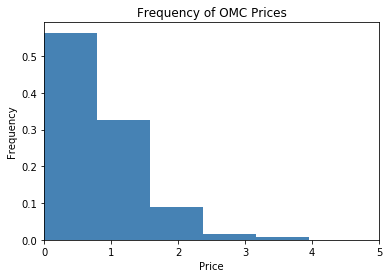

In [8]:
weights = np.ones_like(F_OMC)/float(len(F_OMC))
plt.hist(F_OMC, bins=5,weights=weights, color ='steelblue')
plt.xlabel('Price')
plt.xlim(0.0,5.0)
plt.ylabel('Frequency')
plt.title('Frequency of OMC Prices')
plt.show()

In [9]:
z=abs(ss.norm.cdf(0.025))
#A 95% confidence interval
print('95% confidence interval \n'+
      '[ '+str(MF_OMC-z*np.sqrt(VF_OMC/k))+' ,'+
     str(MF_OMC+z*np.sqrt(VF_OMC/k))+' ]')

95% confidence interval 
[ 0.5565471435328024 ,0.5811424826361491 ]


* **Importance Sampling**

In [29]:
S0 = 95
r = .05
sigma = .15
K = 96
H = 85
T = 0.25
m = 50
k = 1000
n = 1000

Minusb = np.log(H/S0)
c = np.log(K/S0)
h = int(m/2)
dt = T/m

r_1 = 0.06
r_2 = 0.06
theta_1 = - (r_1 + r)/sigma
theta_2 =  (r_2 - r) /sigma

In [30]:
# Repeat 𝑘 times of the 𝑛 simulation Importance Sampling
F_all_IS = np.zeros(n)
F_IS = np.zeros(k)
for i in np.arange(k):
    for j in np.arange(n):
        dW = np.sqrt(dt)*ss.norm.rvs(size = m)
        W_t = dW.cumsum()      ## the path of Brownian Motion
        dL1_t = (- r_1 - 0.5 * sigma**2) *dt + sigma * dW[0:h]   ## the scatter of Lt in the first stage
        dL2_t = (r_2 - 0.5 *sigma**2)*dt + sigma* dW[h:m]       ## the scatter of Lt in the second stage
        L = np.append(dL1_t , dL2_t).cumsum()     ## the path of Lt
        gamma1 = theta_1 * dL1_t.cumsum()[-1] + theta_2 * dL2_t.cumsum()[-1] - (theta_1**2 + theta_2**2)/T/4
        gamma = np.exp(gamma1)
        F_all_IS[j] = 1000*float(L[-1]>c)*float(L.min()<Minusb) * gamma 
    F_IS[i] = F_all_IS.mean()*np.exp(-r*T)

* **IS(Mean; Variance; MSE; Confidence Interval)**

In [31]:
VF_IS = np.var(F_IS)
MF_IS = np.mean(F_IS)
print('Mean of price IS samples :  '+str(MF_IS)+'\n'
     'Variance of price IS samples :  '+str(VF_IS))

Mean of price IS samples :  0.5531066067688276
Variance of price IS samples :  0.34608634157938234


In [32]:
MSEF_IS = np.mean([i*i for i in [i-MF_IS for i in F_IS]])
print('MSE of price IS samples : '+str(MSEF_IS))

MSE of price IS samples : 0.34608634157938234


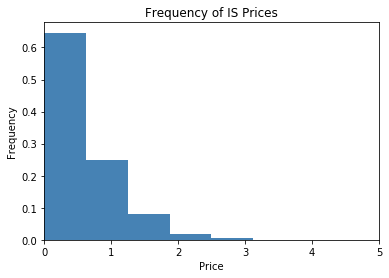

In [33]:
weights = np.ones_like(F_IS)/float(len(F_IS))
plt.hist(F_IS, bins=5,weights=weights, color ='steelblue')
plt.xlabel('Price')
plt.xlim(0.0,5)
plt.ylabel('Frequency')
plt.title('Frequency of IS Prices')
plt.show() 

In [15]:
z=abs(ss.norm.cdf(0.025))
#A 95% confidence interval
print('95% confidence interval \n'+
      '[ '+str(MF_IS-z*np.sqrt(VF_IS/k))+' ,'+
     str(MF_IS+z*np.sqrt(VF_IS/k))+' ]')

95% confidence interval 
[ 0.5319991492883478 ,0.5506456872368464 ]


* **Decision of new probability in IS**

$$\mathbb{E}f(x)=\int f(x)p(x)dx \approx \frac{1}{n}\sum_{i=1}^{n}f(x_i)$$
$$\mathbb{E}f(x)=\int f(x)\frac{p(x)}{q(x)}q(x)dx\approx \frac{1}{n}\sum_{i=1}^{n}f(x_{i})\frac{p(x_{i})}{q(x_i)}$$


**Moral: Choose q(x) large where $\left | f(x) \right |$ p(x) is large**

Find the better choice for r bind

In [22]:
S0 = 95
r = .05
sigma = .15
K = 96
H = 85
T = 0.25
m = 50
k = 1000
n = 1000

Minusb = np.log(H/S0)
c = np.log(K/S0)
p= 10
rb = np.linspace(0.01,2*r,p)

In [23]:
# find the better r
F_var = np.zeros(p)
F_mean = np.zeros(p)
F_all_IS = np.zeros(n)
F_IS = np.zeros(k)
for s in range(p):
    for i in range(k):
        for j in range(n):
            dW = np.sqrt(dt)*ss.norm.rvs(size = m)
            W_t = dW.cumsum()      ## the path of Brownian Motion
            dL1_t = (- rb[s] - 0.5 * sigma**2) *dt + sigma * dW[0:h]   ## the scatter of Lt in the first stage
            dL2_t = (rb[s] - 0.5 *sigma**2)*dt + sigma* dW[h:m]       ## the scatter of Lt in the second stage
            L = np.append(dL1_t , dL2_t).cumsum()     ## the path of Lt
            theta_1 = - (rb[s] + r)/sigma
            theta_2 =  (rb[s] - r) /sigma
            gamma1 = theta_1 * dL1_t.cumsum()[-1] + theta_2 * dL2_t.cumsum()[-1] - (theta_1**2 + theta_2**2)/T/4
            gamma = np.exp(gamma1)
            F_all_IS[j] = 1000*float(L[-1]>c)*float(L.min()<Minusb) * gamma 
        F_IS[i] = F_all_IS.mean()*np.exp(-r*T)
    F_var[s] = np.var(F_IS)
    F_mean[s] = np.mean(F_IS)   

In [24]:
z=ss.norm.cdf(0.05/2)
F_ub = F_mean + np.sqrt(F_var/k)*z
F_lb = F_mean - np.sqrt(F_var/k)*z

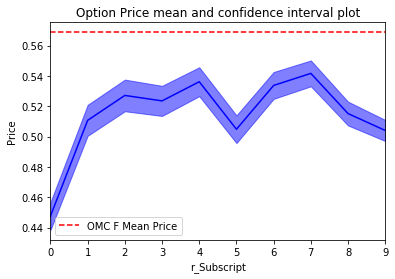

In [25]:
# plot the shaded range of the confidence intervals
plt.fill_between(range(F_mean.shape[0]), F_ub, F_lb,color='b', alpha=.5)
# plot the mean on top
plt.plot(F_mean, 'b')
plt.xlabel('r_Subscript')
plt.xlim(0.0,p-1)
plt.ylabel('Price')
plt.axhline(MF_OMC, color='r', ls='dashed', lw=1.5, label='OMC F Mean Price')
plt.title('Option Price mean and confidence interval plot')
plt.legend()

In [26]:
F_mean

array([0.44763542, 0.51079027, 0.527223  , 0.52361521, 0.53626141,
       0.50492134, 0.53382145, 0.54176667, 0.51525576, 0.50410303])

In [27]:
F_var

array([0.32537704, 0.40199839, 0.41986568, 0.38038244, 0.3505265 ,
       0.32212892, 0.30211924, 0.28042506, 0.23756542, 0.1862156 ])